# Exploring NFL Play by Play Data with NFLScrapR

[NFLscrapR](https://github.com/maksimhorowitz/nflscrapR) is an awesome R library which queries the official NFL API for play-by-play data, and parses it into an R dataframe. Data is available from 2009 through the latest week of the current season. In this blog post, I'll explore the seven full seasons of play-by-play data available from 2009-2015. 

## Getting the Data

To downnload a season of play by play data to an R dataframe, execute the following in an R session:
```
#Download and Load nflScrapR package
devtools::install_github(repo = "maksimhorowitz/nflscrapR")   
library('nflscrapR')

#Create DataFrame with 2015 play by play data
pbp_2015 <- season_play_by_play(2015)

```

## Initial Exploration: Data Shape, Available Varriable Names

After using nflScrapR in an R session to download and save play by play data for 2009-2015, below I explore the data in Python.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

nfl_data = pd.read_csv('/home/max/nfl_stats/data/pbp_2009_2015.csv', low_memory=False)

In [3]:
#Print (Rows, Columns) of Data
print(nfl_data.shape)

#Print Variable-Names and First Two Values for Each Variable. 
with pd.option_context('display.max_rows', 999, 'display.max_colwidth', 25):
    print(nfl_data.head(2).transpose())

(316711, 69)
                                           0                         1
Date                              2009-09-10                2009-09-10
GameID                            2009091000                2009091000
Drive                                      1                         1
qtr                                        1                         1
down                                     NaN                         1
time                                   15:00                     14:53
TimeUnder                                 15                        15
TimeSecs                                3600                      3593
PlayTimeDiff                               0                         7
SideofField                              TEN                       PIT
yrdln                                     30                        42
yrdline100                                30                        58
ydstogo                                    0                    

How cool is this?! Almost any question I can think of regarding NFL play outcomes is suddenly queryable. Although first, we'll clarify exactly what info some of the variables include.

## Checking Available Categories for Certain Categorical Variables

Some of the variables look categorical, but it's not obvious what the categories are. We can check, and get the percentage occurrence of each category, using DataFrame.value_counts() with the "normalize=True" option. 

(the ".to_frame()" included below is just included to suppress "dtype:float64" from being printed below each value_counts section.)

In [4]:
selected_columns = ['PassOutcome', 'PassLength', 'PassLocation', 'RunLocation', 'RunGap', 'PlayType']
for c in selected_columns:
    print(nfl_data[c].value_counts(normalize=True).to_frame(), '\n')

                 PassOutcome
Complete            0.600491
Incomplete Pass     0.399509 

       PassLength
Short    0.805235
Deep     0.194765 

        PassLocation
right       0.406493
left        0.359939
middle      0.233568 

        RunLocation
right      0.365658
left       0.361986
middle     0.272356 

          RunGap
end     0.358684
tackle  0.337954
guard   0.303362 

                    PlayType
Pass                0.390138
Run                 0.298294
Kickoff             0.057478
Punt                0.054371
No Play             0.051927
Timeout             0.039673
Sack                0.026289
Extra Point         0.024865
Field Goal          0.021767
Quarter End         0.011177
Two Minute Warning  0.008746
QB Kneel            0.008708
End of Game         0.004859
Spike               0.001623
Half End            0.000082 



Wow, that's a lot of play types. For most statistics we'd be interested in, we'd want to restrict our plays to runs and passes. Although the PlayTypes above show us that we'll need to include Sacks as Passes since Sacks occur during pass attempts.  

In [6]:
#Create new DataFrame where Play-Type is Run/Pass/Sack
run_pass_row_indices = nfl_data[nfl_data['PlayType'].isin(['Run', 'Pass', 'Sack'])].index

runs_passes_sacks = nfl_data.loc[run_pass_row_indices, :]

## Exploring Quick High-Level Stats

What's the average yards gained per play?

In [8]:
runs_passes_sacks['Yards.Gained'].mean()

5.511941155681216

What percentage of plays are run vs pass?

In [9]:
runs_passes_sacks['PlayType'].value_counts(normalize=True).to_frame()

PlayType
Pass  0.545861
Run   0.417357
Sack  0.036782

So pass attempts comprise 54.6% + 3.7%(sacks) = 58.3% of plays. The other 41.7% are runs. At least from 2009-2015.

On first downs?

In [10]:
first_downs = runs_passes_sacks[runs_passes_sacks['down']==1]
first_downs['PlayType'].value_counts(normalize=True).to_frame()

PlayType
Run   0.512585
Pass  0.461843
Sack  0.025572

What percentage of coaches' challenges are successful?

In [25]:
nfl_data['ChalReplayResult'].value_counts(normalize=True).to_frame()

ChalReplayResult
Upheld             0.59193
Reversed           0.40807

...(a challenge is successful if it reverses the call on the field, so 41% of challenges are successful) 

What are the average yards gained per pass-play and per run-play?

In [26]:
runs_passes_sacks.groupby('PlayType')['Yards.Gained'].mean().to_frame()

Yards.Gained
PlayType              
Pass          7.188320
Run           4.378500
Sack         -6.505285

## More on Run vs Pass Yards Per Play

So Passes look way more productive on average. How is that affected by including Sacks as Pass Attempts?

In [16]:
runs_passes_sacks['PlayType2'] = runs_passes_sacks['PlayType'].replace({'Sack':'Pass'})
runs_passes_sacks.groupby('PlayType2')['Yards.Gained'].mean()

PlayType2
Pass    6.323845
Run     4.378500
Name: Yards.Gained, dtype: float64

So including sacks drops pass plays by almost 0.9 yards-per-play, or about 12%. Even with sacks included though, passes still look way more effective on average; about 2 yards-per-play more effective, which is almost 50% more yards-per-play than the run plays. I wonder how consistent that is by year.

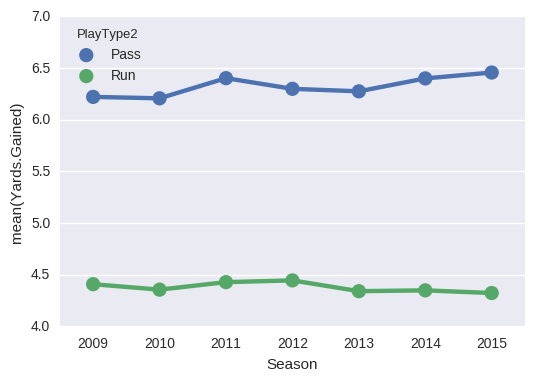

In [158]:
annual = runs_passes_sacks.groupby(['PlayType2', 'Season'], as_index=False)['Yards.Gained'].mean()
sn.pointplot(data=annual, x='Season', y='Yards.Gained', hue='PlayType2')#, scale=0.75)

Yep, the heavy average premium in pass vs run yards-per-play goes back at least to 2009.